In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import tarfile
import random
from tensorflow import keras

from os import listdir
from datetime import datetime
# from keras.preprocessing.image import ImageDataGenerator

In [2]:
tarf = tarfile.open('./fer2013.tar.gz')
tarf.extractall()

In [3]:
emotion_strings = [
    'Angry'      # 0
    , 'Disgust'  # 1
    , 'Fear'     # 2
    , 'Happy'    # 3
    , 'Sad'      # 4
    , 'Surprise' # 5
    , 'Neutral'  # 6
]

def emo_to_string(emotion):
    return emotion_strings[np.argmax(emotion)]

for i in range(7):
    arr = np.zeros(shape=(7))
    arr[i] = 1
    print(emo_to_string(arr))

Angry
Disgust
Fear
Happy
Sad
Surprise
Neutral


(35887, 48, 48)
(35887, 48, 48, 1)


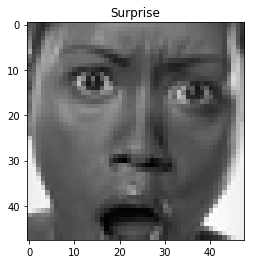

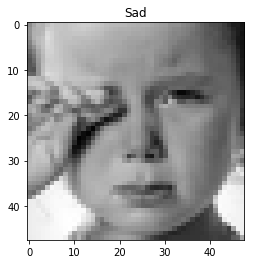

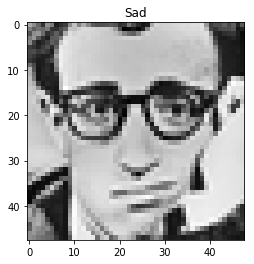

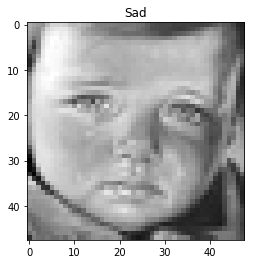

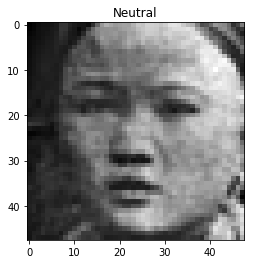

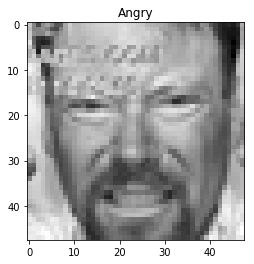

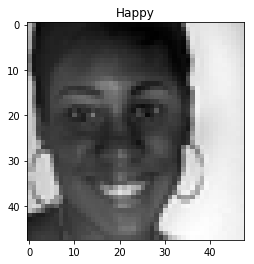

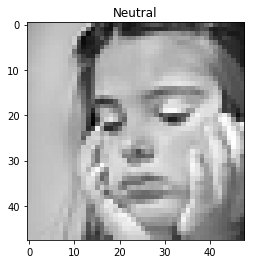

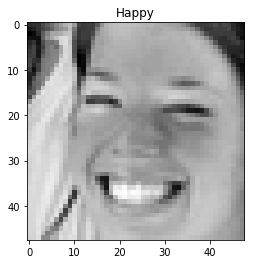

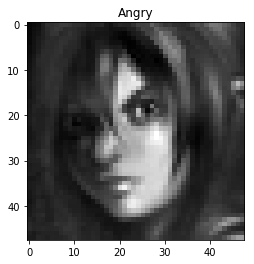

In [73]:
data = pd.read_csv('./fer2013/fer2013.csv')
width = 48
height = 48

# Covert pixels column to a list
pixels = data['pixels'].tolist()
emotions = pd.get_dummies(data['emotion']).values

faces = []

for pixel_sequence in pixels:
    # Split the string by space character as a list
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    
    # convert to numpy array
    face = np.asarray(face).reshape(width, height)
    
    faces.append(face.astype('float32'))
    
faces = np.asarray(faces)
print(faces.shape)
# subtract mean from each image
faces = np.asarray([img - np.mean(img) for img in faces])
# set image norm to be 100
faces = (faces*100)/255.0
# subtract mean from each pixel
faces = faces - np.mean(faces, axis=0)
# devide by standart deviation
faces = faces - np.std(faces, axis=0)

# center data
faces = faces - np.mean(faces)

faces = np.expand_dims(faces, -1)
print(faces.shape)

r = np.random.randint(len(faces), size=10)
for i in r:
    img = faces[i,:,:,0];
    plt.imshow(img, cmap='gray')
    plt.title(emo_to_string(emotions[i]))
    plt.show()

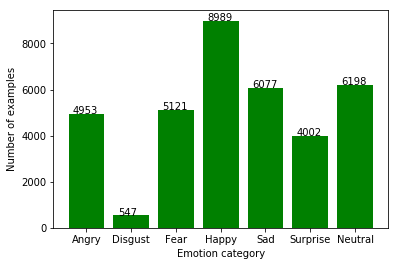

In [9]:
# obtain counts for each of the categories
counts = collections.Counter([np.argmax(row) for row in emotions])

emo_ids = list(counts.keys())
emo_counts = list(list(counts.values()))
bars = plt.bar(emo_ids, emo_counts, color='g')
plt.xticks(emo_ids, [emotion_strings[i] for i in emo_ids])
plt.xlabel("Emotion category")
plt.ylabel("Number of examples")
for i, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(bar.get_x() + 0.1, y + 1, emo_counts[i])
plt.show()

In [125]:
train_count = 28709
val_count = 3589
test_count = 3589
num_channels = 1
num_classes = 7

perm = np.random.permutation(faces.shape[0])
train_dataset = faces[perm[:train_count]]
train_labels = emotions[perm[:train_count]]
valid_dataset = faces[perm[train_count:train_count+val_count]]
valid_labels = emotions[perm[train_count:train_count+val_count]]
test_dataset = faces[perm[train_count+val_count:]]
test_labels = emotions[perm[train_count+val_count:]]

datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=45,
                                                      zoom_range=[0.8, 1.2],
                                                      horizontal_flip=True,
                                                      width_shift_range=3.0)
datagen.fit(train_dataset)

def convert_row(row):
    row = np.asarray([-1 if i==0 else 1 for i in row])
    return row

train_labels = np.asarray([convert_row(row) for row in train_labels])
valid_labels = np.asarray([convert_row(row) for row in valid_labels])
test_labels = np.asarray([convert_row(row) for row in test_labels])

# Change width and height to the new values
width = 42
height = 42

def resize(set):
    return np.asarray([np.resize(example, new_shape=(width, height, 1)) for example in set])


print('Train: %s %s' % (train_dataset.shape, train_labels.shape))
print('Validation: %s %s' % (valid_dataset.shape, valid_labels.shape))
print('Test: %s %s' % (test_dataset.shape, test_labels.shape))

Train: (28709, 48, 48, 1) (28709, 7)
Validation: (3589, 48, 48, 1) (3589, 7)
Test: (3589, 48, 48, 1) (3589, 7)


In [25]:
def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    
    return tf.nn.relu(x)

def maxpool2d(x, k=2, strides=1, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, strides, strides, 1], padding=padding)

def averagepool2d(x, k=2, strides=1, padding='SAME'):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, strides, strides, 1], padding=padding)
    

In [26]:
def l2_svm(logits, labels):
    return tf.square(tf.maximum(tf.zeros(tf.shape(labels)), 
                                    1 - labels*logits))

Implementation of the solution proposed in https://arxiv.org/pdf/1511.04110.pdf
Architecture consists of:


*  2 traditional CNN modules
*  2 Inception-style modules



In [33]:
def svm_net(x, weights, biases, keep_prob=0.5, train=True):
    conv1 = conv2d(x, weights['conv1'], biases['conv1'], strides=1) # 42 x 42 x 32
    conv1 = maxpool2d(conv1, strides=2, padding='SAME') # 21 x 21 x 32
    
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'], strides=1) # 21 x 21 x 32
    conv2 = averagepool2d(conv2, strides=2, padding='VALID') # 10 x 10 x 32
    
    conv3 = conv2d(conv2, weights['conv3'], biases['conv3'], strides=1) # 10 x 10 x 64 
    conv3 = averagepool2d(conv3, strides=2)
    
    fc1 = tf.reshape(conv3, [-1, weights['fc1'].get_shape().as_list()[0]])
    fc1 = tf.nn.relu(tf.matmul(fc1, weights['fc1']) + biases['fc1'])
    if train:
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    out = tf.matmul(fc1, weights['out']) + biases['out']
#     out = batch_normalization(out, biases['out'], train, conv_layer=False)
    return out


In [34]:
def accuracy(predictions, labels):
    equality = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(equality, tf.float32))

In [157]:
graph = tf.Graph()
keep_prob = 0.7
svm_C = 0.4
beta = 0.9
# initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
# initializer = tf.contrib.layers.xavier_initializer()
initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.01)

with graph.as_default(), tf.device('/gpu:0'):
    weights = {
        'conv1': tf.get_variable('conv1', shape=(5,5,1,32), 
                           initializer=initializer),
        'conv2': tf.get_variable('conv2', shape=(4,4,32,32), 
                           initializer=initializer),
        'conv3': tf.get_variable('conv3', shape=(5,5,32,64),
                           initializer=initializer),
        'fc1': tf.get_variable('fc1', shape=(1600,3072),
                           initializer=initializer),
        'out': tf.get_variable('out', shape=(3072,7), 
                           initializer=initializer)
    }
    biases = {
        'conv1': tf.get_variable('conv1_bias', shape=(32), 
                        initializer=tf.zeros_initializer()),
        'conv2': tf.get_variable('conv2_bias', shape=(32), 
                        initializer=tf.zeros_initializer()),
        'conv3': tf.get_variable('conv3_bias', shape=(64),
                        initializer=tf.zeros_initializer()),
        'fc1': tf.get_variable('fc1_bias', shape=(3072), 
                        initializer=tf.zeros_initializer()),
        'out': tf.get_variable('out_bias', shape=(7), 
                        initializer=tf.zeros_initializer())
    }
    
    tf_train_dataset = tf.placeholder(tf.float32, [None, width, height, num_channels])
    tf_train_labels = tf.placeholder(tf.float32, [None, num_classes])
    tf_valid_dataset = tf.constant(resize(valid_dataset), tf.float32)
    tf_valid_labels = tf.constant(valid_labels, tf.float32)
    tf_test_dataset = tf.constant(resize(test_dataset))
    
    logits = svm_net(tf_train_dataset, weights, biases, keep_prob)
    svm_loss = svm_C * tf.reduce_mean(l2_svm(logits, tf_train_labels))
    l2_reg = 0.5 * tf.reduce_sum(tf.square(weights['out']))
    loss = l2_reg + svm_loss
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    tf_loss_summary = tf.summary.scalar('loss', loss) # scalar summary for the loss
    
    # define exponential learning rate
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.placeholder(tf.float32, shape=())
#     learning_rate = tf.train.exponential_decay(starter_learning_rate,
#                                                  global_step,
#                                                  1000, 0.9, staircase=True)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=beta).minimize(loss)
    
    train_accuracy = accuracy(logits, tf_train_labels) # calculate train accuracy
    tf_train_acc_sum = tf.summary.scalar('train_accuracy', train_accuracy) # train accuracy summary
    merged_train_sum = tf.summary.merge([tf_loss_summary, tf_train_acc_sum]) # merge scalars
    
    # calculate prediction, loss and accuracy on validation set
    valid_prediction = svm_net(tf_valid_dataset, weights, biases, train=False) 
    valid_accuracy = accuracy(valid_prediction, tf_valid_labels)
    valid_loss = svm_C * tf.reduce_mean(l2_svm(valid_prediction, tf_valid_labels)) + tf.reduce_sum(tf.square(weights['out']))/2.0
    tf_valid_loss_sum = tf.summary.scalar('validation_loss', valid_loss)
    tf_valid_acc_sum = tf.summary.scalar('validation_accuracy', valid_accuracy)
    valid_summary = tf.summary.merge([tf_valid_loss_sum, tf_valid_acc_sum])
    
    # calculate prediction on test set
    test_prediction = svm_net(tf_test_dataset, weights, biases, train=False)  
    test_accuracy = accuracy(test_prediction, test_labels)  
    
    # define saver
    saver = tf.train.Saver()

In [164]:
batch_size = 128
num_epochs = 1000
global_step = 0
train_writer = tf.summary.FileWriter("logs/tang/scalars/train/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
valid_writer = tf.summary.FileWriter("logs/tang/scalars/valid/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

valid_dataset = resize(valid_dataset)
test_dataset = resize(test_dataset)

def set_lr(epoch):
    if epoch<40:
        return 0.1
    elif epoch<100:
        return 0.01
    elif epoch<400:
        return 0.001
    else:
        return 0.0001

def set_batch_size(epoch):
    if epoch < 200:
        return 128
    else:
        return 256

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    tf.global_variables_initializer().run()
    for epoch in range(num_epochs):
        batch_size = set_batch_size(epoch)
        steps_per_epoch = int(train_dataset.shape[0]/batch_size) + 1
        lr = set_lr(epoch)
        for step in range(steps_per_epoch):
            start = (step*batch_size)%train_count
            end = start+batch_size if start+batch_size < train_count else train_count
#             idx = np.random.randint(train_dataset.shape[0], size=batch_size)
            batch = resize(train_dataset[start:end])
            labels = train_labels[start:end]
#             batch, labels = next(datagen.flow(train_dataset, train_labels, shuffle=False, batch_size=batch_size))
#             batch=resize(batch)
            if(start<end):
                _, l, summary, acc = sess.run([optimizer, loss, merged_train_sum, 
                                                 train_accuracy],
                                             feed_dict={tf_train_dataset: batch,
                                                       tf_train_labels: labels,
                                                       learning_rate: lr})
            train_writer.add_summary(summary, global_step)
            global_step += 1
        print('Minibatch loss at epoch %d: %f learning_rate: %f' % (epoch, l, lr))
        print('Validation accuracy %f' % (valid_accuracy.eval()))
        print('Minibatch accuracy %f' % (acc))
        saver.save(sess, './saved_models/svm')
        val_summary = sess.run(valid_summary)
        valid_writer.add_summary(val_summary, global_step)
    print("Test accuracy: %f" % (test_accuracy.eval()))

Minibatch loss at epoch 0: 0.190693 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 1: 0.190692 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 2: 0.190691 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 3: 0.190692 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 4: 0.190689 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 5: 0.190690 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 6: 0.190690 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 7: 0.190687 learning_rate: 0.100000
Validation accuracy 0.250766
Minibatch accuracy 0.189189
Minibatch loss at epoch 8: 0.190683 learning_rate: 0.100000
Vali

KeyboardInterrupt: 

In [174]:
with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    latest_checkpoint = tf.train.latest_checkpoint('./saved_models/')
    saver.restore(sess,latest_checkpoint)
    lr = 0.001
    _, l, summary, acc = sess.run([optimizer, loss, merged_train_sum, train_accuracy],
                                             feed_dict={tf_train_dataset: batch,
                                                       tf_train_labels: labels,
                                                       learning_rate: lr})
    print(l)

0.12898654
